##  Getting started with Cell Types Database

Using data from the Allen Cell Types Database requires downloading multiple files and metadata from the API. 

Use the [CellTypesCache](http://alleninstitute.github.io/AllenSDK/allensdk.core.html#allensdk.core.cell_types_cache.CellTypesCache) class to fetch data from the API and to help organized the metadata and the downloaded files

In [16]:
from allensdk.core.cell_types_cache import CellTypesCache

# !! update this path so that it points to your external hard drive !!
ctc = CellTypesCache(manifest_file='D:/cell_types/manifest.json')

# get metadata for all the cells
cells_sdk = ctc.get_cells()
print "There are %d cells in the cache" % len(cells_sdk)

There are 248 cells in the cache


## Munge and process data to create a pandas dataframe for downstream analysis





In [17]:
import re

# helper function to break up structure into regions and layer
def split_region_layer(cell) :
    a = cell['structure']['acronym']
    si = 0
    for idx,x in enumerate(a) :
        if x.isdigit() :
            si = idx
            break
    return {'region': a[:si], 'layer': a[si:]}
    
print split_region_layer(cells_sdk[0])

{'region': u'VISp', 'layer': u'4'}


In [18]:
# helper function to get the mouse line
def transgenic_drivers( cell ) :
    tlist = cell['donor']['transgenic_lines']
    dlist = [str(x['name']) for x in tlist if x['transgenic_line_type_name'] == 'driver' ]
    return {'mouse_line':";".join( dlist )}

print transgenic_drivers(cells_sdk[0])

{'mouse_line': 'Sst-IRES-Cre'}


In [19]:
# create temporary record dictionary with the metadata we want to keep

index_key = ['id']
sample_keys = ['mouse_line','region','layer','hemisphere']
annotation_keys = ['dendrite_type','apical']
modality_keys = ['has_morphology', 'has_reconstruction']

def filter_list(keys,exclude_keys) : 
    return [ x for x in keys if x not in exclude_keys ]

def clean_keys(keys) :
    return [ str(x) for x in keys ]

# cell soma location keys
csl_keys = cells_sdk[0]['cell_soma_locations'][0].keys()
exclude_csl_keys = ['id','specimen_id']
csl_keys = clean_keys(filter_list( csl_keys, exclude_csl_keys))

# ephys feature keys
ef_keys = cells_sdk[0]['ephys_features'][0].keys()
exclude_ef_keys = ['id','specimen_id']
ef_keys = clean_keys(filter_list( ef_keys, exclude_ef_keys ))

# neuron reconstruction keys
c = [ x for x in cells_sdk if x['has_reconstruction']][0]
nr_keys = c['neuron_reconstructions'][0].keys()
exclude_nr_keys = ['id','specimen_id','tags']
nr_keys = clean_keys(filter_list( nr_keys, exclude_nr_keys ))

columns = index_key + sample_keys + annotation_keys + modality_keys + csl_keys + ef_keys + nr_keys


In [20]:
def filter_dictonary_by_keys( d, k ) :
     return { x: d[x] for x in k }
    
def fetch_data( c ) :
    d = filter_dictonary_by_keys( c, (index_key + annotation_keys + modality_keys + ['hemisphere']) )
    d.update( split_region_layer(c) )
    d.update( transgenic_drivers(c) )
    d.update( filter_dictonary_by_keys( c['cell_soma_locations'][0], csl_keys) )
    d.update( filter_dictonary_by_keys( c['ephys_features'][0], ef_keys) )
    if c['has_reconstruction'] :
        d.update( filter_dictonary_by_keys( c['neuron_reconstructions'][0], nr_keys ) )
    return d

cells_records = [fetch_data(c) for c in cells_sdk]
    
print cells_records[0]['mouse_line']

Sst-IRES-Cre


In [21]:
# create pandas dataframe
import pandas as pd

cells_df = pd.DataFrame.from_records( cells_records, index = 'id', columns=columns )
cells_df.head()

,mouse_line,region,layer,hemisphere,dendrite_type,apical,has_morphology,has_reconstruction,normalized_depth,reference_space_id,...,number_stems,number_branches,average_fragmentation,average_contraction,average_bifurcation_angle_remote,hausdorff_dimension,total_surface,max_branch_order,soma_surface,overall_height
id,,,,,,,,,,,,,,,,,,,,,
324257146,Sst-IRES-Cre,VISp,4,left,aspiny,NA,True,True,0.410398,9,...,6,30,34.2333,0.776329,77.4101,1.12107,1416.64,6,111.175,215.758
469622566,Scnn1a-Tg3-Cre,VISp,5,right,spiny,truncated,True,False,0.423992,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
328876201,Sst-IRES-Cre,VISp,5,left,aspiny,NA,False,False,0.510874,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
466431949,Scnn1a-Tg3-Cre,VISl,4,left,spiny,truncated,True,False,0.464470,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
396903227,Scnn1a-Tg3-Cre,VISp,5,right,spiny,truncated,False,False,0.497223,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
cells_df.columns.values

array(['mouse_line', 'region', 'layer', 'hemisphere', 'dendrite_type',
       'apical', 'has_morphology', 'has_reconstruction',
       'normalized_depth', 'reference_space_id', 'y', 'x', 'z', 'tau',
       'upstroke_downstroke_ratio_short_square', 'thumbnail_sweep_id',
       'has_delay', 'threshold_v_ramp', 'peak_v_short_square', 'avg_isi',
       'sag', 'blowout_voltage', 'trough_t_ramp', 'slow_trough_v_ramp',
       'slow_trough_v_long_square', 'has_pause', 'electrode_0_pa',
       'trough_v_long_square', 'input_resistance_mohm', 'latency',
       'fast_trough_v_ramp', 'trough_t_long_square',
       'threshold_t_long_square', 'rheobase_sweep_id', 'peak_t_ramp',
       'threshold_t_short_square', 'has_burst',
       'slow_trough_t_long_square', 'fast_trough_t_long_square', 'ri',
       'threshold_v_short_square', 'upstroke_downstroke_ratio_ramp',
       'vm_for_sag', 'threshold_i_long_square',
       'initial_access_resistance', 'peak_t_long_square',
       'threshold_i_short_square'

In [34]:
cells_df.save('cells_dataframe.h5')

## Take a look at some dataset statistics using the dataframe

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# count number of cells by mouse_line
mouse_line_groups = cells_df.groupby(['mouse_line'])
mouse_line_groups.size()

mouse_line
Gad2-IRES-Cre      12
Htr3a-Cre_NO152    15
Nr5a1-Cre          30
Ntsr1-Cre           8
Pvalb-IRES-Cre     51
Rbp4-Cre_KL100     12
Rorb-IRES2-Cre     31
Scnn1a-Tg2-Cre     17
Scnn1a-Tg3-Cre     36
Sst-IRES-Cre       36
dtype: int64

In [26]:
# count layer by mouse_line
mouse_line_groups['layer'].value_counts()

mouse_line          
Gad2-IRES-Cre    5       8
                 4       3
                 6a      1
Htr3a-Cre_NO152  2/3     9
                 4       4
                 5       2
Nr5a1-Cre        4      24
                 2/3     3
                 5       2
                 6a      1
Ntsr1-Cre        6a      7
                 5       1
Pvalb-IRES-Cre   5      31
                 4      10
                 2/3     5
                 6a      5
Rbp4-Cre_KL100   5       9
                 6a      2
                 4       1
Rorb-IRES2-Cre   4      17
                 5      10
                 2/3     2
                 6a      2
Scnn1a-Tg2-Cre   4       9
                 5       8
Scnn1a-Tg3-Cre   4      25
                 5      11
Sst-IRES-Cre     5      22
                 6a      7
                 2/3     5
                 4       2
dtype: int64

In [27]:
# count dendrite_type by mouse_line
mouse_line_groups['dendrite_type'].value_counts()

mouse_line                     
Gad2-IRES-Cre    aspiny            12
Htr3a-Cre_NO152  aspiny            15
Nr5a1-Cre        spiny             28
                 aspiny             2
Ntsr1-Cre        spiny              8
Pvalb-IRES-Cre   aspiny            51
Rbp4-Cre_KL100   spiny             12
Rorb-IRES2-Cre   spiny             30
                 aspiny             1
Scnn1a-Tg2-Cre   spiny             16
                 aspiny             1
Scnn1a-Tg3-Cre   spiny             35
                 aspiny             1
Sst-IRES-Cre     aspiny            33
                 sparsely spiny     2
                 spiny              1
dtype: int64

In [28]:
# average upstroke/downstroke ratio by mouse_line
mouse_line_groups[['upstroke_downstroke_ratio_short_square']].mean()

,upstroke_downstroke_ratio_short_square
mouse_line,
Gad2-IRES-Cre,1.594569
Htr3a-Cre_NO152,2.336137
Nr5a1-Cre,3.439860
Ntsr1-Cre,2.764741
Pvalb-IRES-Cre,1.433088
Rbp4-Cre_KL100,3.325245
Rorb-IRES2-Cre,3.501382
Scnn1a-Tg2-Cre,3.523081
Scnn1a-Tg3-Cre,3.529249


In [29]:
# average max_euclidean_distance by mouse_line
mouse_line_groups[['max_euclidean_distance']].mean()

,max_euclidean_distance
mouse_line,
Gad2-IRES-Cre,229.198000
Htr3a-Cre_NO152,193.325000
Nr5a1-Cre,316.766917
Ntsr1-Cre,555.668667
Pvalb-IRES-Cre,238.118222
Rbp4-Cre_KL100,539.851500
Rorb-IRES2-Cre,415.419400
Scnn1a-Tg2-Cre,465.101833
Scnn1a-Tg3-Cre,439.672375


In [30]:
# sort mouse lines by averge upstroke/downstroke ratio
param = 'upstroke_downstroke_ratio_short_square'
sorted = cells_df.ix[mouse_line_groups[[param]].transform(np.mean).sort(param).index].groupby(['mouse_line'],sort=False)
sorted[param].mean()
sorted_lines = [k for k,gp in sorted]
print sorted_lines

['Pvalb-IRES-Cre', 'Gad2-IRES-Cre', 'Sst-IRES-Cre', 'Htr3a-Cre_NO152', 'Ntsr1-Cre', 'Rbp4-Cre_KL100', 'Nr5a1-Cre', 'Rorb-IRES2-Cre', 'Scnn1a-Tg2-Cre', 'Scnn1a-Tg3-Cre']


## Use seaborn to see the distribution of upstroke/downstroke ratio by mouse line and layer

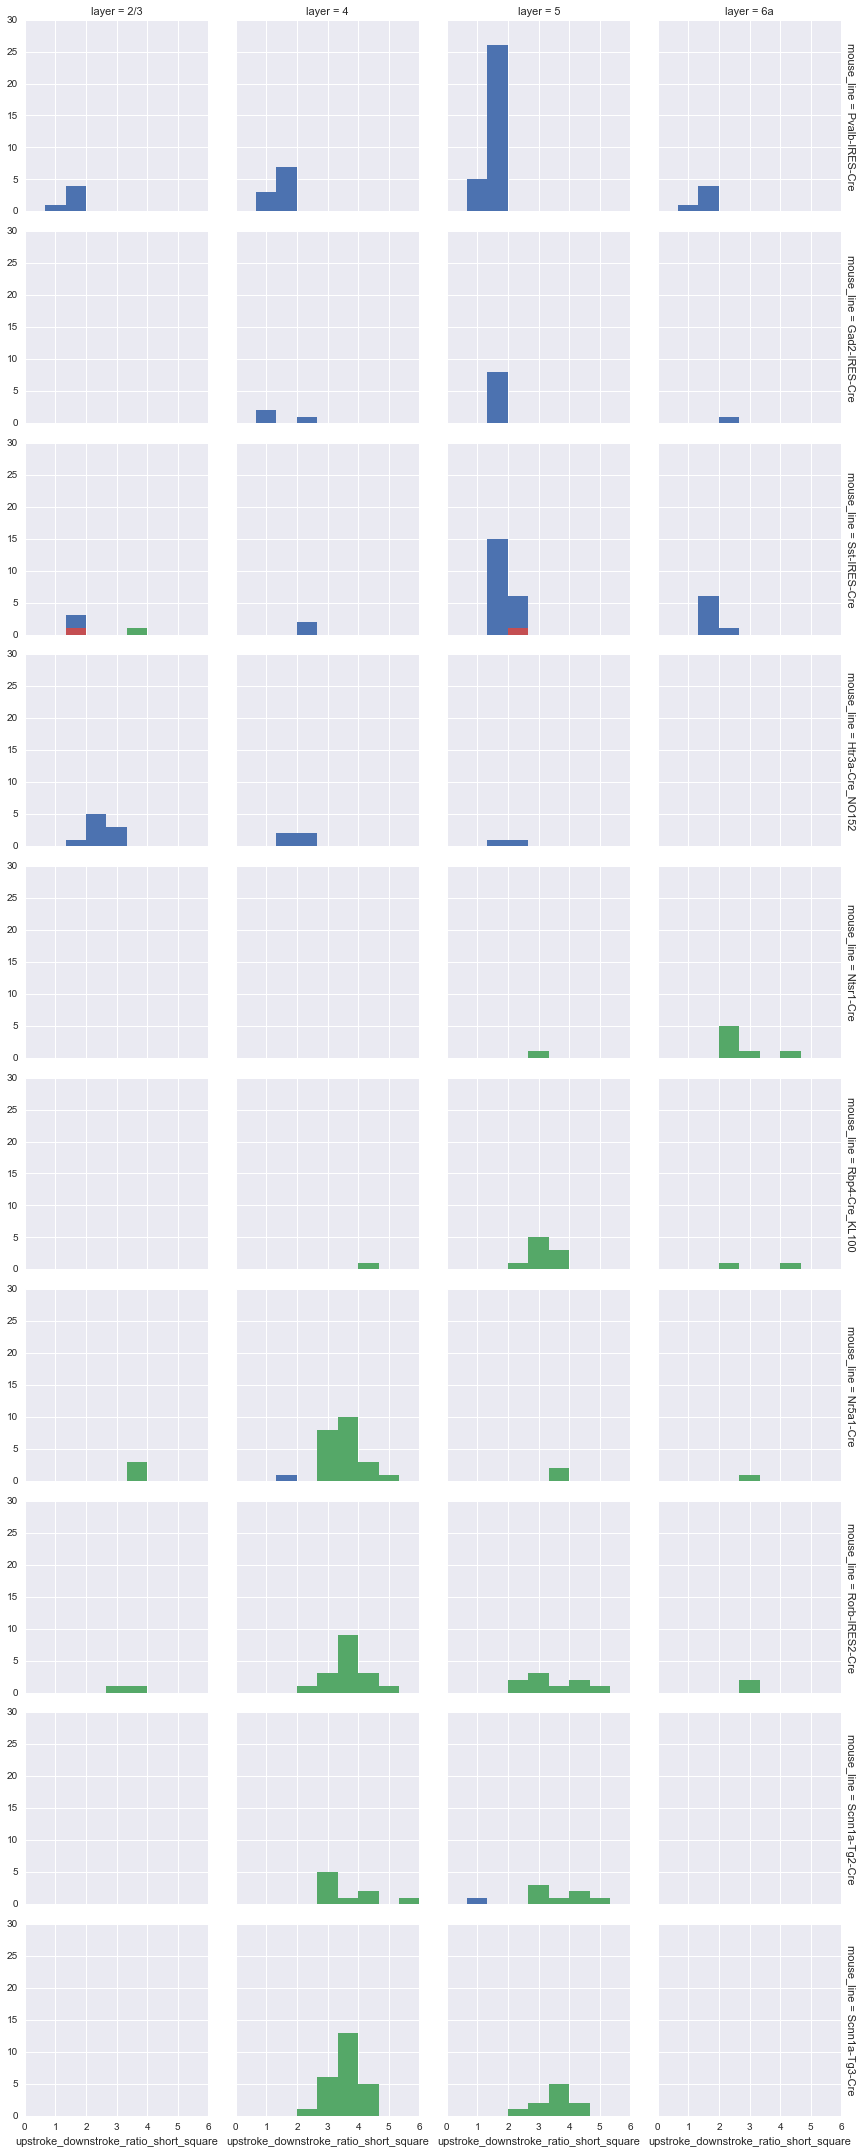

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

max_value = math.ceil(cells_df['upstroke_downstroke_ratio_short_square'].max())
bins = np.linspace(0,max_value,10)

sns.set(style="darkgrid")

g = sns.FacetGrid(cells_df, row="mouse_line", col="layer", hue="dendrite_type", 
                  col_order=['2/3','4','5','6a'], row_order=sorted_lines, margin_titles=True)

g.map(plt.hist, "upstroke_downstroke_ratio_short_square", bins=bins, lw=0)